# Importaciones para el proyecto:

In [3]:
import sys
import os
print(os.getcwd())
sys.path.append(os.path.abspath("../"))

c:\Users\Usuario\REPO_BOOTCAMP\ML_Adidas-Forecast\src\results_notebook


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.bootcampviztools as bt
import utils.toolbox_ML as tb
import utils.funciones_eda as fe

# ✅ Step 1: Objetivo del proyecto.


### ADIDAS Y SUS DISTRIBUIDORES EN UNITED STATES. 🔎

Adidas quiere saber una predicción razonable de cuánto facturarán las tiendas distribuidoras para asi saber si los productos que solicitan son adecuados a su nivel de facturación. Es muy importante que el producto esté en el lugar más eficiente posible y para ello debemos predecirlo.

A su vez, quieren plantear un sistema logístico para los Estados de USA donde haya más demanda de producto. Considerando asi una prevención a la rotura de stock y a la mejora en costes ya que el producto más vendido en cada Estado estaría más cerca de dichas tiendas distribuidoras.

🤔 PREGUNTAS QUE NOS HACEMOS 🤔

A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS 💵
- ¿Qué mercado es el que está en auge para estos años?
- ¿Hay algún mercado que debamos conocer que vaya en declive?
- ¿Cumplirán las tiendas con el mínimo de facturación deseable?
- ¿Varía la facturación con la estacionalidad?

B. PREVENCIÓN A LA ROTURA DE STOCK Y MEJORA EN COSTES 🚛
- ¿En qué regiones debemos tener un centro logístico más potente para el futuro?
- ¿Cuánto stock por categoría deberá estar disponible en cada región?

# ✅ Step 2: Obtener datos.


In [5]:
file_path = "../data/adidas_sales.csv"

In [6]:
df = pd.read_csv(file_path)
df.head(5)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Sales Method
0,Walmart,1128299,6/17/2021,Southeast,Florida,Orlando,Women's Apparel,$103.00,218,"2,245","$1,257",Online
1,West Gear,1128299,7/16/2021,South,Louisiana,New Orleans,Women's Apparel,$103.00,163,"1,679",$806,Online
2,Sports Direct,1197831,8/25/2021,South,Alabama,Birmingham,Men's Street Footwear,$10.00,700,"7,000","$3,150",Outlet
3,Sports Direct,1197831,8/27/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,575,"8,625","$3,881",Outlet
4,Sports Direct,1197831,8/21/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,475,"7,125","$3,206",Outlet


---------
A simple vista vemos:
- Columnas espaciadas.
- Error en el cálculo de ***"Total Sales"***
- Columnas que vamos a limpiar para tener el DataFrame lo más funcional posible.

Y más cosas que veremos en el siguiente paso

# ✅ Step 3: Limpieza de datos - Correcciones.


- Solucionamos las columnas espaciadas:

In [7]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   retailer          9641 non-null   object
 1   retailer_id       9641 non-null   int64 
 2   invoice_date      9641 non-null   object
 3   region            9641 non-null   object
 4   state             9641 non-null   object
 5   city              9641 non-null   object
 6   product           9641 non-null   object
 7   price_per_unit    9639 non-null   object
 8   units_sold        9641 non-null   object
 9   total_sales       9641 non-null   object
 10  operating_profit  9641 non-null   object
 11  sales_method      9641 non-null   object
dtypes: int64(1), object(11)
memory usage: 904.0+ KB


- Valores faltantes en ***"price_per_unit"*** pero antes solucionaremos el error de cálculo en ***"total_sales"***
- Tenemos tipo object en todas las columnas, debemos transformar a númericas algunas.
- Queremos transformar ***"invoice_date"*** en datetime.
- Vamos a eliminar columnas no relevantes al proyecto.

In [9]:
df.sample(1)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
523,Foot Locker,1185732,7/5/2021,Southeast,South Carolina,Charleston,Women's Street Footwear,$51.00,248,"1,265",$455,Online


- Si vemos el *sample* podemos ver que la multiplicación en ***"total_sales"*** (*price_per_unit* y *units_sold*) no es correcta. Vamos a hacerla de nuevo y corregiremos el símbolo del dollar. La haremos tipo numérica. Por último añadiremos dos decimales en las columnas.

In [10]:
df["price_per_unit"] = df["price_per_unit"].str.replace("$", "")
df["price_per_unit"] = pd.to_numeric(df["price_per_unit"], errors="coerce")

In [11]:
# Visión general de los datos
df.sample(6)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
4392,West Gear,1128299,10/17/2021,South,Louisiana,New Orleans,Women's Street Footwear,42.0,100,420,$210,Online
1716,Sports Direct,1197831,9/10/2021,South,Alabama,Birmingham,Men's Apparel,35.0,179,627,$326,Outlet
9082,Sports Direct,1128299,1/13/2021,West,New Mexico,Albuquerque,Women's Athletic Footwear,40.0,300,"12,000","$4,800",Online
2841,Kohl's,1185732,8/11/2021,West,Wyoming,Cheyenne,Women's Street Footwear,38.0,143,543,$245,Online
8312,Foot Locker,1185732,11/10/2020,Midwest,Minnesota,Minneapolis,Men's Street Footwear,50.0,445,"22,250","$7,788",In-store
3719,Kohl's,1189833,3/1/2021,Midwest,Montana,Billings,Women's Athletic Footwear,39.0,119,464,$255,Online


In [12]:
df["units_sold"] = pd.to_numeric(df["units_sold"].str.replace(",", ""),errors="coerce")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9639 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   object 
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 904.0+ KB


Siendo columnas numéricas ya podríamos calcular el correcto "total_sales" pero vamos a visualizar los nulos primero antes de tocar los datos.

In [14]:
df[df.isnull().any(axis=1)]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
6725,Foot Locker,1185732,1/29/2020,Northeast,New York,New York,Men's Apparel,NaN,850,"51,000","$15,300",Outlet
7882,Sports Direct,1197831,7/29/2020,South,Texas,Houston,Men's Apparel,NaN,500,"20,000","$6,000",Outlet


---------
🤔 Esto seria una pregunta para "Negocio" porque tenemos dos soluciones para afrontar estos nulos.
1. Entendemos que la división de ***"total_sales"*** / ***"units_sold"*** dan el resultado de ***"price_per_unit"***
2. Hemos visto que hay valores de ***"total_sales"*** que no fueron bien calculados y todos tienen en común la falta del último dígito.

Ya que son dos valores faltantes, vamos a confiar en los valores que tenemos del dataset y haremos la opción 1

In [15]:
df["total_sales"] = pd.to_numeric(df["total_sales"].str.replace(",", ""),errors="coerce")


In [16]:
df["price_per_unit"] = df["price_per_unit"].fillna(df["total_sales"] / df["units_sold"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9641 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   int64  
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 904.0+ KB


- Calculamos los valores correctos de ***"total_sales"***

In [18]:
df['total_sales'] = df['price_per_unit'] * df['units_sold']

In [19]:
df.sample(5)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
4566,Amazon,1185732,1/14/2021,Northeast,Massachusetts,Boston,Men's Athletic Footwear,42.0,94,3948.0,$237,Online
4509,Sports Direct,1197831,9/21/2021,South,Alabama,Birmingham,Women's Athletic Footwear,58.0,95,5510.0,$391,Online
4774,Sports Direct,1197831,3/26/2021,South,Tennessee,Knoxville,Men's Apparel,27.0,88,2376.0,$97,Outlet
2808,Amazon,1185732,11/5/2021,Northeast,Maine,Portland,Men's Street Footwear,52.0,144,7488.0,$337,Online
3342,Foot Locker,1128299,2/23/2021,West,Idaho,Boise,Men's Athletic Footwear,28.0,128,3584.0,$154,Outlet


- DateTime para ***"invoice_date"*** y ordenamos el DataFrame

In [20]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

In [21]:
df = df.sort_values(by="invoice_date")
df.head(3)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
4908,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,$243,Online
30,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,$679,Outlet
4937,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,$141,Outlet


In [22]:
df.isnull().sum()

retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

- Eliminamos columnas irrelevantes y hacemos una copia de seguridad del dataset

In [23]:
df = df.drop(columns=["retailer_id", "operating_profit", "sales_method"])

# "operation_profit" se elimina porque no tenemos contexto sobre los gastos para entender realmente el profit

- Una vista rápida para saber si está todo en orden

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9641 entries, 4908 to 3413
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9641 non-null   object        
 1   invoice_date    9641 non-null   datetime64[ns]
 2   region          9641 non-null   object        
 3   state           9641 non-null   object        
 4   city            9641 non-null   object        
 5   product         9641 non-null   object        
 6   price_per_unit  9641 non-null   float64       
 7   units_sold      9641 non-null   int64         
 8   total_sales     9641 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 753.2+ KB


In [25]:
df.region.value_counts()

region
West         2446
Northeast    2376
Midwest      1869
South        1726
Southeast    1224
Name: count, dtype: int64

In [26]:
df.state.value_counts()

state
Texas             430
California        430
New York          360
Florida           360
Mississippi       216
Massachusetts     216
Oklahoma          216
Rhode Island      216
Oregon            216
Virginia          216
Vermont           216
Pennsylvania      216
Idaho             216
New Mexico        216
New Hampshire     216
Utah              216
Arizona           216
Tennessee         216
Arkansas          216
Alabama           216
Nevada            216
Connecticut       216
Georgia           216
Louisiana         216
Maine             144
South Carolina    144
Nebraska          144
Colorado          144
West Virginia     144
Wyoming           144
Washington        144
Minnesota         144
Montana           144
Iowa              144
Ohio              144
Kentucky          144
Alaska            144
North Dakota      144
Michigan          144
Indiana           144
Hawaii            144
New Jersey        144
Maryland          144
South Dakota      144
Wisconsin         144
Dela

In [27]:
df.city.value_counts()

city
Portland          360
Charleston        288
Philadelphia      216
Albuquerque       216
New York          216
Boston            216
Oklahoma City     216
Providence        216
Richmond          216
Burlington        216
Jackson           216
Boise             216
Little Rock       216
Manchester        216
Salt Lake City    216
Phoenix           216
Los Angeles       216
Knoxville         216
Birmingham        216
Orlando           216
Dallas            216
New Orleans       216
Hartford          216
Las Vegas         216
Atlanta           216
Houston           214
San Francisco     214
Anchorage         144
Omaha             144
Denver            144
Miami             144
Seattle           144
Cheyenne          144
Minneapolis       144
Billings          144
Des Moines        144
Columbus          144
Louisville        144
St. Louis         144
Fargo             144
Detroit           144
Indianapolis      144
Honolulu          144
Baltimore         144
Newark            144
Sioux

In [28]:
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Women's Athletic Footwear    1605
Men's Apparel                1604
Men's aparel                    1
Name: count, dtype: int64

In [29]:
# Error de ortografía
df["product"] = df["product"].replace({"Men's aparel": "Men's Apparel"})
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Women's Athletic Footwear    1605
Men's Apparel                1605
Name: count, dtype: int64

In [30]:
df.retailer.value_counts()

retailer
Foot Locker      2634
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

In [31]:
# Comentamos el código para no ejecutarlo de nuevo, pero este sería el dataset limpiado
# df.to_csv("../data/adidas_sales_cleaned.csv", index=False)

# ✅ Step 4: Train y Test.


In [32]:
df_cleaned = pd.read_csv("../data/adidas_sales_cleaned.csv", parse_dates=["invoice_date"])

In [33]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9641 non-null   object        
 1   invoice_date    9641 non-null   datetime64[ns]
 2   region          9641 non-null   object        
 3   state           9641 non-null   object        
 4   city            9641 non-null   object        
 5   product         9641 non-null   object        
 6   price_per_unit  9641 non-null   float64       
 7   units_sold      9641 non-null   int64         
 8   total_sales     9641 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 678.0+ KB


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [34]:
X = df_cleaned.drop(columns=["total_sales"])
y = df_cleaned["total_sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7712, 8) (1929, 8) (7712,) (1929,)


----------------

B. PREVENCIÓN A LA ROTURA DE STOCK Y MEJORA EN COSTES

# ✅ Step 5: Mini Eda.


A. PREDECIR LA FACTURACIÓN DE LAS TIENDAS DISTRIBUIDORAS

In [35]:
tb.describe_df(X_train)

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
retailer,object,0,6,0.08
invoice_date,datetime64[ns],0,716,9.28
region,object,0,5,0.06
state,object,0,50,0.65
city,object,0,52,0.67
product,object,0,6,0.08
price_per_unit,float64,0,94,1.22
units_sold,int64,0,343,4.45


ONE-HOT ENCODING

In [36]:
X_train = pd.get_dummies(X_train, columns=["region", "state", "city"], prefix=["region","state", "city"])
X_test = pd.get_dummies(X_test, columns=["region","state", "city"], prefix=["region","state", "city"])

In [37]:
X_train = pd.get_dummies(X_train, columns=["retailer"], prefix="retailer")
X_test = pd.get_dummies(X_test, columns=["retailer"], prefix="retailer")

In [38]:
X_train = pd.get_dummies(X_train, columns=["product"], prefix="product")
X_test = pd.get_dummies(X_test, columns=["product"], prefix="product")


Para transformar nuestra fecha voy a escoger el **mes** y los **dias de la semana** como información importante. Lo haremos con el seno y el coseno porque es importante el comportamiento cíclico de la fecha. Con el One-Hot Encoding crea columnas separadas y el modelo interpretará cada valor como algo independiente.

In [39]:
X_train['month_sin'] = np.sin(2 * np.pi * X_train['invoice_date'].dt.month / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['invoice_date'].dt.month / 12)

X_test['month_sin'] = np.sin(2 * np.pi * X_test['invoice_date'].dt.month / 12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['invoice_date'].dt.month / 12)

X_train['day_of_week_sin'] = np.sin(2 * np.pi * X_train['invoice_date'].dt.dayofweek / 7)
X_train['day_of_week_cos'] = np.cos(2 * np.pi * X_train['invoice_date'].dt.dayofweek / 7)

X_test['day_of_week_sin'] = np.sin(2 * np.pi * X_test['invoice_date'].dt.dayofweek / 7)
X_test['day_of_week_cos'] = np.cos(2 * np.pi * X_test['invoice_date'].dt.dayofweek / 7)


In [40]:
X_train.columns = (
    X_train.columns
    .str.replace(" ", "_")
    .str.replace("'", "")
)

X_test.columns = (
    X_test.columns
    .str.replace(" ", "_")
    .str.replace("'", "")
)

In [41]:
print(f"Columnas de X_train: {X_train.columns}")
print(f"Columnas de X_test: {X_test.columns}")

Columnas de X_train: Index(['invoice_date', 'price_per_unit', 'units_sold', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_Southeast', 'region_West',
       'state_Alabama', 'state_Alaska',
       ...
       'product_Mens_Apparel', 'product_Mens_Athletic_Footwear',
       'product_Mens_Street_Footwear', 'product_Womens_Apparel',
       'product_Womens_Athletic_Footwear', 'product_Womens_Street_Footwear',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object', length=126)
Columnas de X_test: Index(['invoice_date', 'price_per_unit', 'units_sold', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_Southeast', 'region_West',
       'state_Alabama', 'state_Alaska',
       ...
       'product_Mens_Apparel', 'product_Mens_Athletic_Footwear',
       'product_Mens_Street_Footwear', 'product_Womens_Apparel',
       'product_Womens_Athletic_Footwear', 'product_Womens_Street_Footwear',
       'month_sin', 'month_cos', 'd

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7712 entries, 532 to 7270
Columns: 126 entries, invoice_date to day_of_week_cos
dtypes: bool(119), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.3 MB


In [43]:
columnas_categoricas = X_train.select_dtypes(include=["object", "bool"]).columns
print(columnas_categoricas)

Index(['region_Midwest', 'region_Northeast', 'region_South',
       'region_Southeast', 'region_West', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'state_California',
       ...
       'retailer_Kohls', 'retailer_Sports_Direct', 'retailer_Walmart',
       'retailer_West_Gear', 'product_Mens_Apparel',
       'product_Mens_Athletic_Footwear', 'product_Mens_Street_Footwear',
       'product_Womens_Apparel', 'product_Womens_Athletic_Footwear',
       'product_Womens_Street_Footwear'],
      dtype='object', length=119)


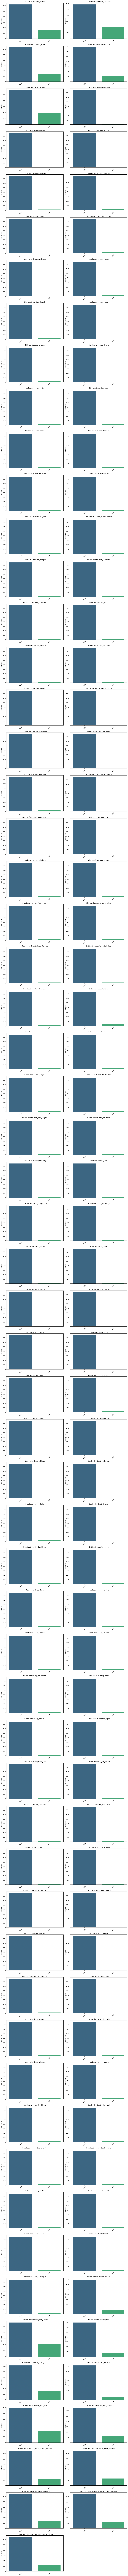

In [44]:
bt.pinta_distribucion_categoricas(X_train, columnas_categoricas)

In [45]:
columnas_numericas = X_train.select_dtypes(include=["float64", "int64"]).columns
print(columnas_numericas)

Index(['price_per_unit', 'units_sold', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


<Axes: >

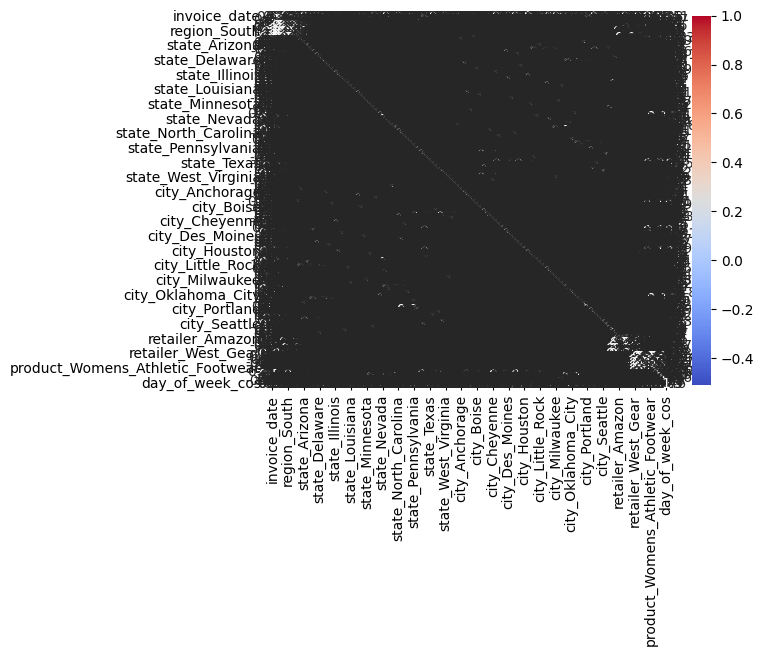

In [46]:
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm")

(6, 2)


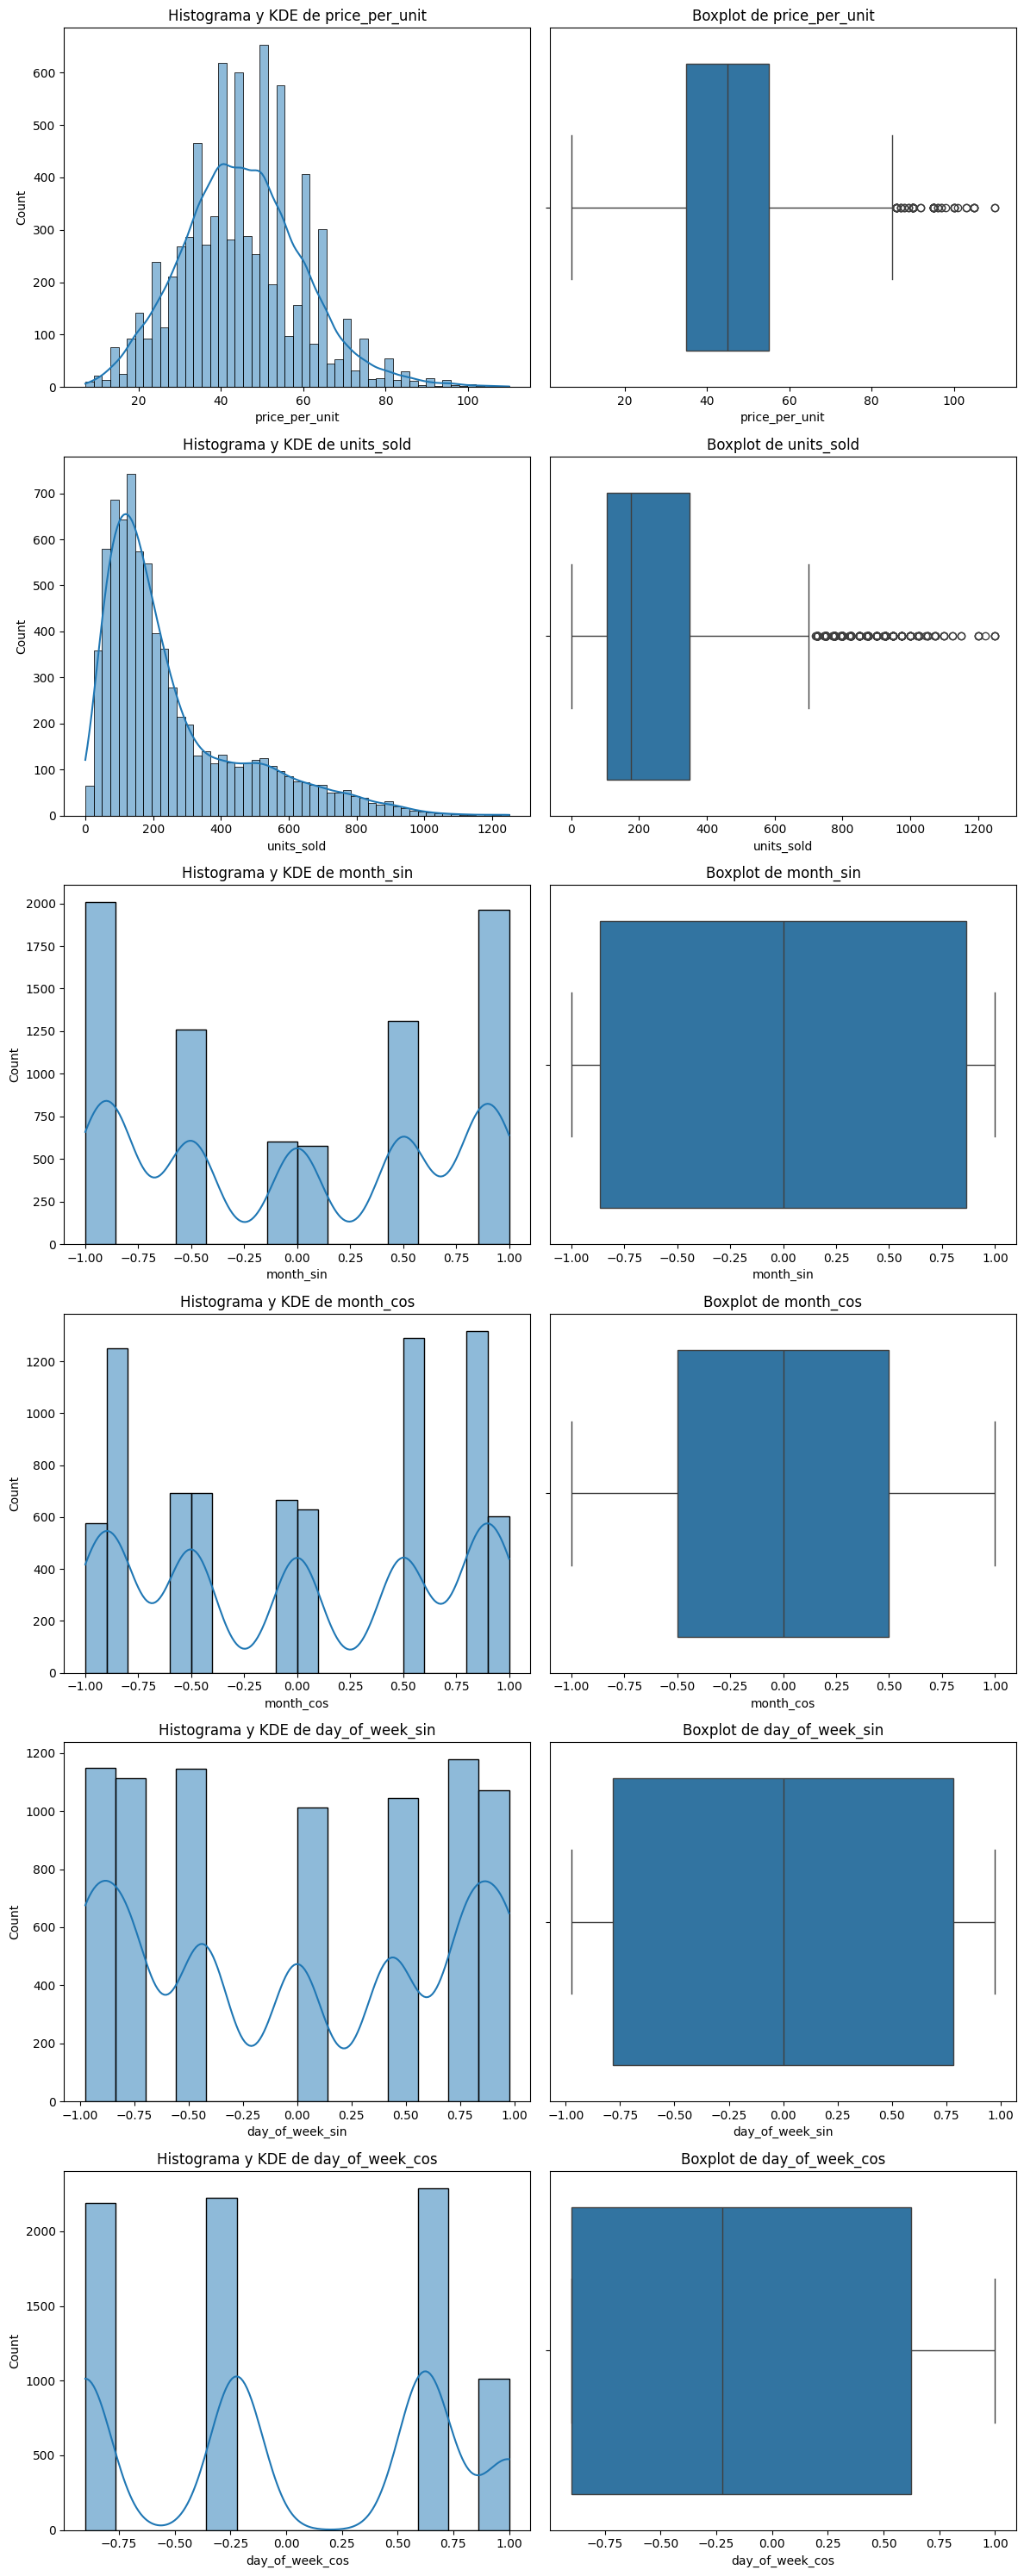

In [47]:
bt.plot_combined_graphs(X_train, columnas_numericas)

Vamos a suavizar ***"units_sold"*** con una transformación logaritmica

In [48]:
X_train["units_sold_log"] = np.log1p(X_train["units_sold"])
X_test["units_sold_log"] = np.log1p(X_test["units_sold"])
units_sold_log_viz = X_train["units_sold_log"]

columnas_numericas = X_train.select_dtypes(include=["float64", "int64"]).columns
print(columnas_numericas)

Index(['price_per_unit', 'units_sold', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'units_sold_log'],
      dtype='object')


(7, 2)


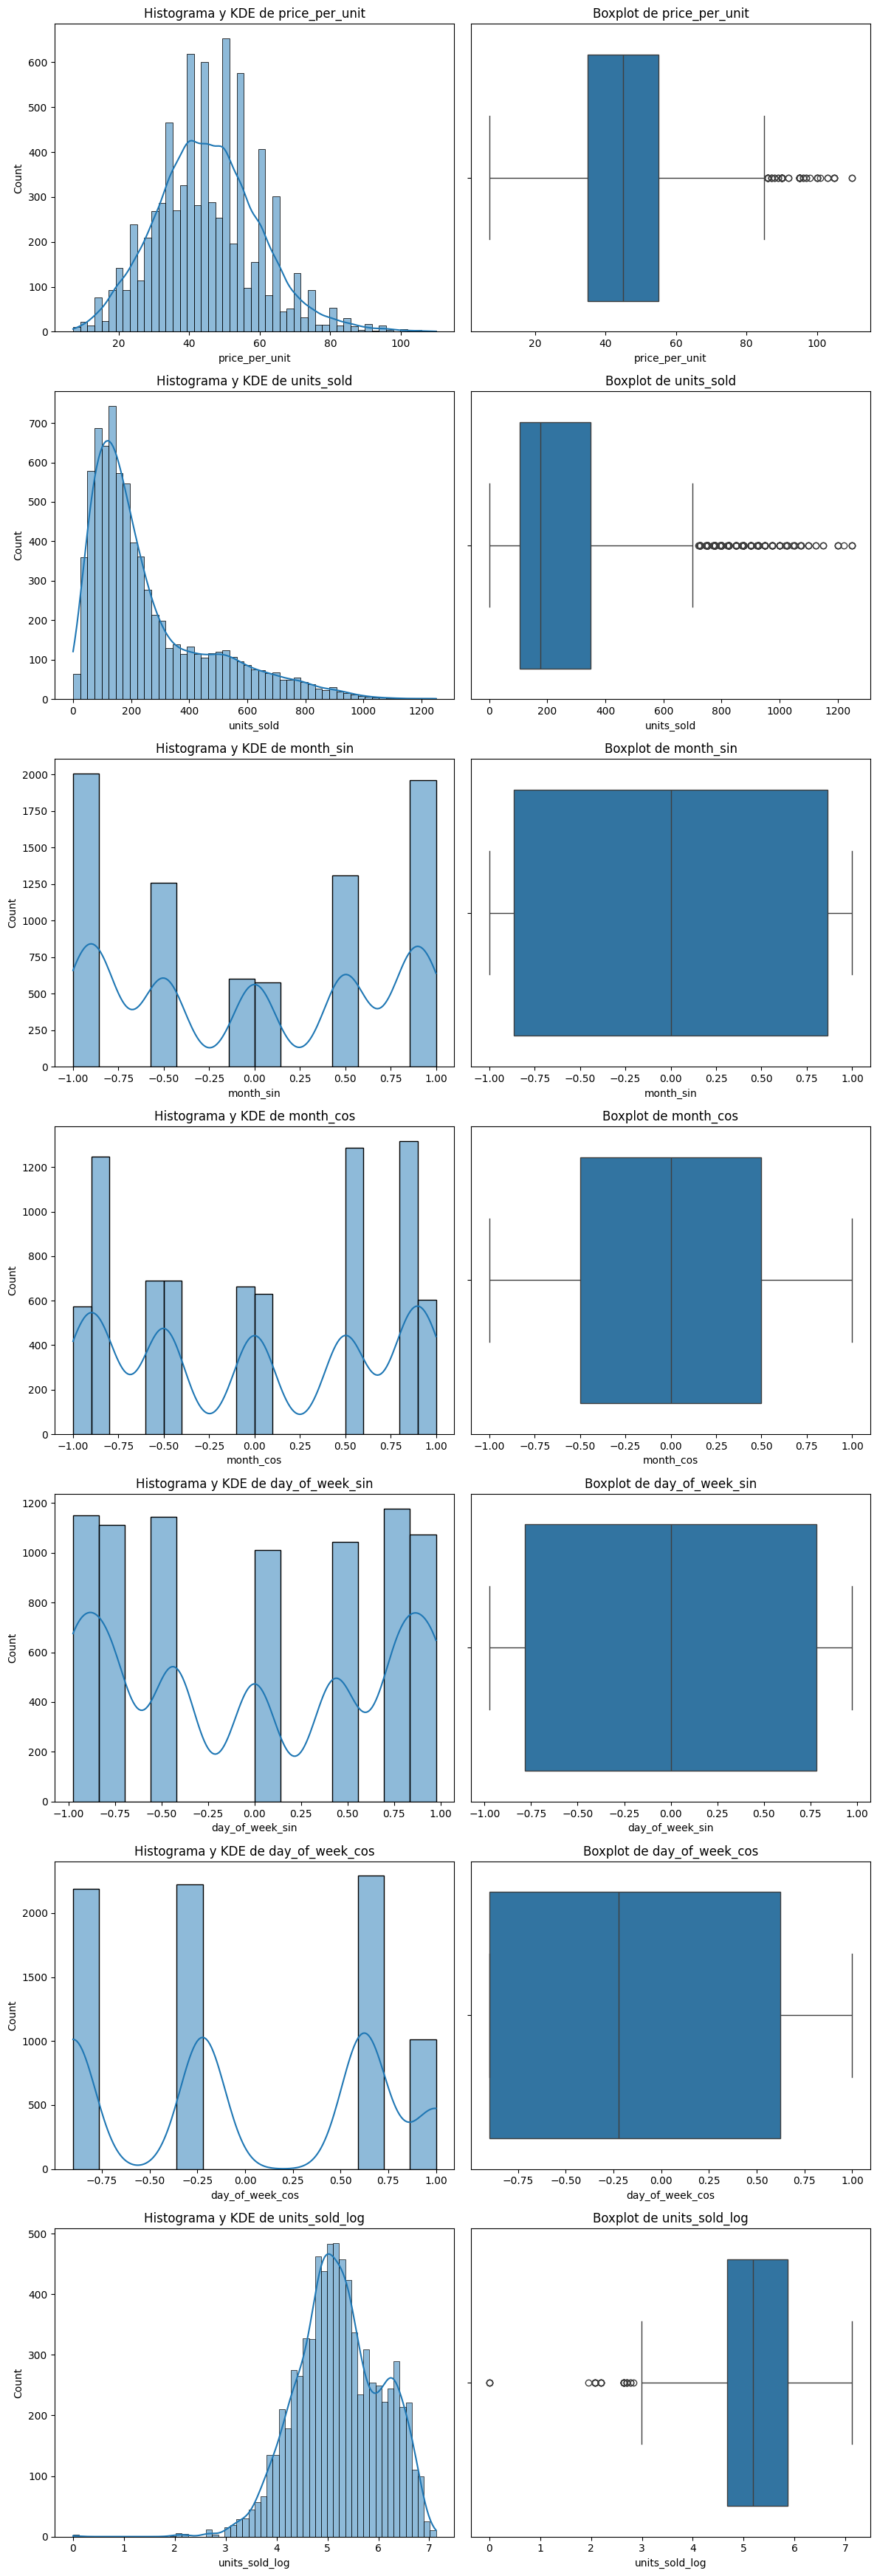

In [49]:
bt.plot_combined_graphs(X_train, columnas_numericas)

In [50]:
X_train

,invoice_date,price_per_unit,units_sold,region_Midwest,region_Northeast,region_South,region_Southeast,region_West,state_Alabama,state_Alaska,...,product_Mens_Athletic_Footwear,product_Mens_Street_Footwear,product_Womens_Apparel,product_Womens_Athletic_Footwear,product_Womens_Street_Footwear,month_sin,month_cos,day_of_week_sin,day_of_week_cos,units_sold_log
532,2020-05-02,70.0,975,False,True,False,False,False,False,False,...,False,False,True,False,False,5.000000e-01,-8.660254e-01,-0.974928,-0.222521,6.883463
485,2020-04-24,52.0,196,False,False,False,True,False,False,False,...,False,False,False,False,False,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,5.283204
2075,2021-02-05,36.0,113,True,False,False,False,False,False,False,...,False,False,False,True,False,8.660254e-01,5.000000e-01,-0.433884,-0.900969,4.736198
1222,2020-12-08,32.0,34,True,False,False,False,False,False,False,...,False,False,False,False,False,-2.449294e-16,1.000000e+00,0.781831,0.623490,3.555348
6458,2021-08-14,58.0,91,False,True,False,False,False,False,False,...,False,False,True,False,False,-8.660254e-01,-5.000000e-01,-0.974928,-0.222521,4.521789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2021-07-12,49.0,119,True,False,False,False,False,False,False,...,True,False,False,False,False,-5.000000e-01,-8.660254e-01,0.000000,1.000000,4.787492
5191,2021-06-17,61.0,223,False,False,False,True,False,False,False,...,False,True,False,False,False,1.224647e-16,-1.000000e+00,0.433884,-0.900969,5.411646
5390,2021-06-24,61.0,184,False,False,False,True,False,False,False,...,False,False,False,True,False,1.224647e-16,-1.000000e+00,0.433884,-0.900969,5.220356
860,2020-08-16,42.0,168,False,False,True,False,False,False,False,...,False,False,False,False,False,-8.660254e-01,-5.000000e-01,-0.781831,0.623490,5.129899


Visualizamos nuestro target - y_train

<Axes: xlabel='total_sales'>

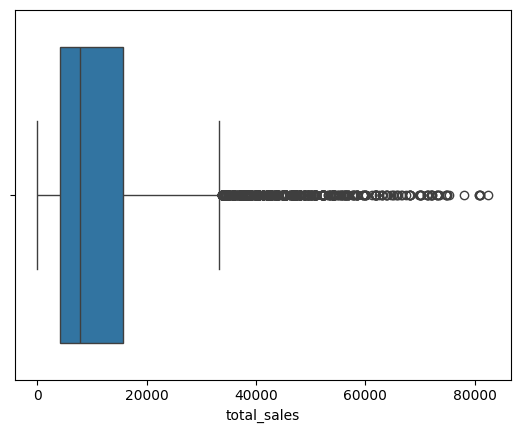

In [51]:
sns.boxplot(x=y_train)

<Axes: xlabel='total_sales', ylabel='Count'>

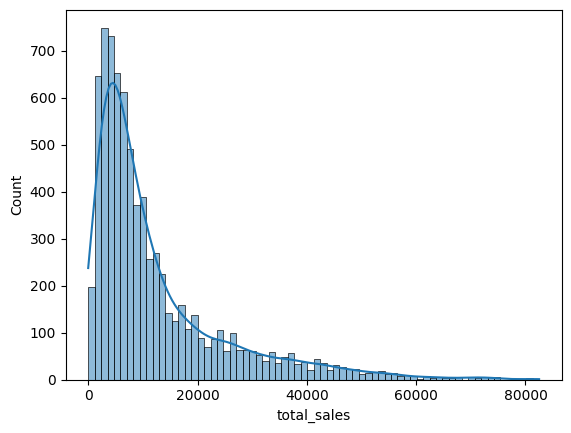

In [52]:
sns.histplot(y_train, kde = True)

Hay una distribución asimétrica porque habrán muchas tiendas que tengan niveles bajos o moderados. Pocas tiendas logran grandes facturaciones.

Nuestro modelo puede verse afectado por esta distribución asimetrica, debemos hacer una transformación logaritmica.

In [53]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

<Axes: xlabel='total_sales', ylabel='Count'>

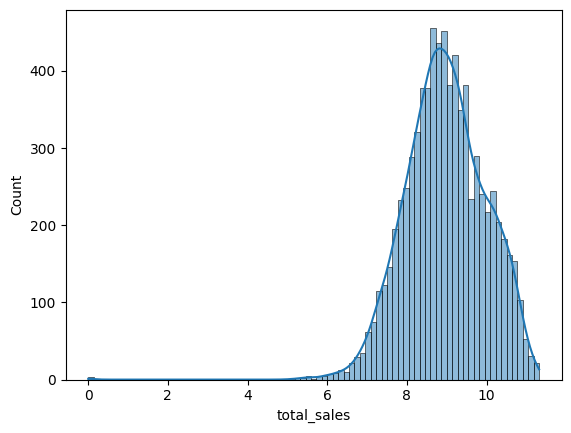

In [54]:
sns.histplot(y_train_log, kde = True)

En estos casos con tantas columnas / features es imposible ver bien un HEATMAP. Lo solucionamos asi:

- Considero que tenemos la información relevante sobre las fechas : mes y dias de la semana
- Procedo a eliminar la columna con datetime ***"invoice_date"*** y haremos Feature Importance con Random Forest

In [55]:
X_train = X_train.drop(columns=["invoice_date", "units_sold"])
X_test = X_test.drop(columns=["invoice_date", "units_sold"])

In [56]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

RandomForestRegressor(random_state=42)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18368\3207993305.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.importance[:20], y=feature_importances.feature[:20], palette="viridis")


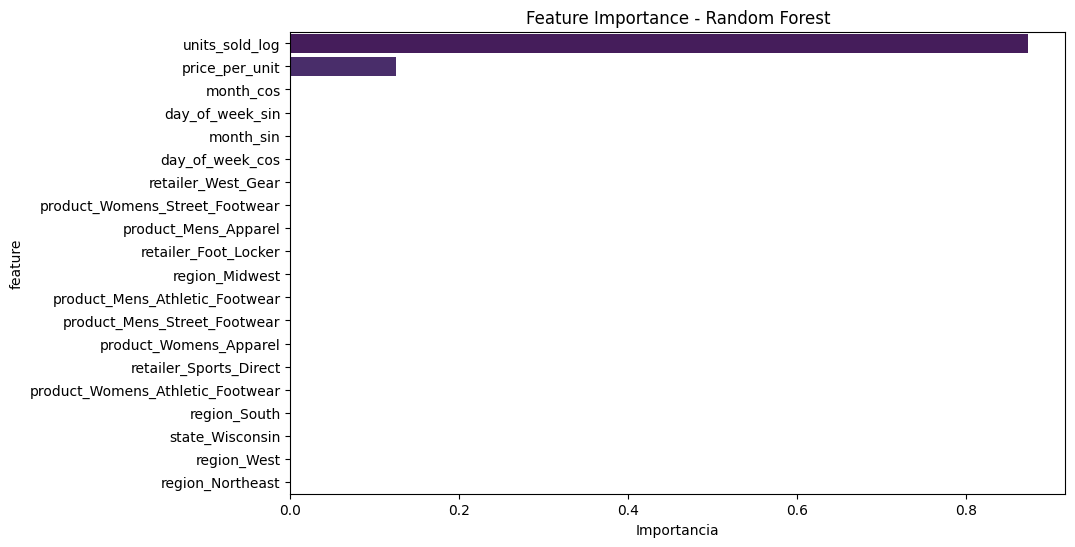

In [57]:
feature_importances = pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance[:20], y=feature_importances.feature[:20], palette="viridis")
plt.xlabel("Importancia")
plt.title("Feature Importance - Random Forest")
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18368\1807826985.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_xgb.importance[:20], y=feature_importances_xgb.feature[:20], palette="coolwarm")


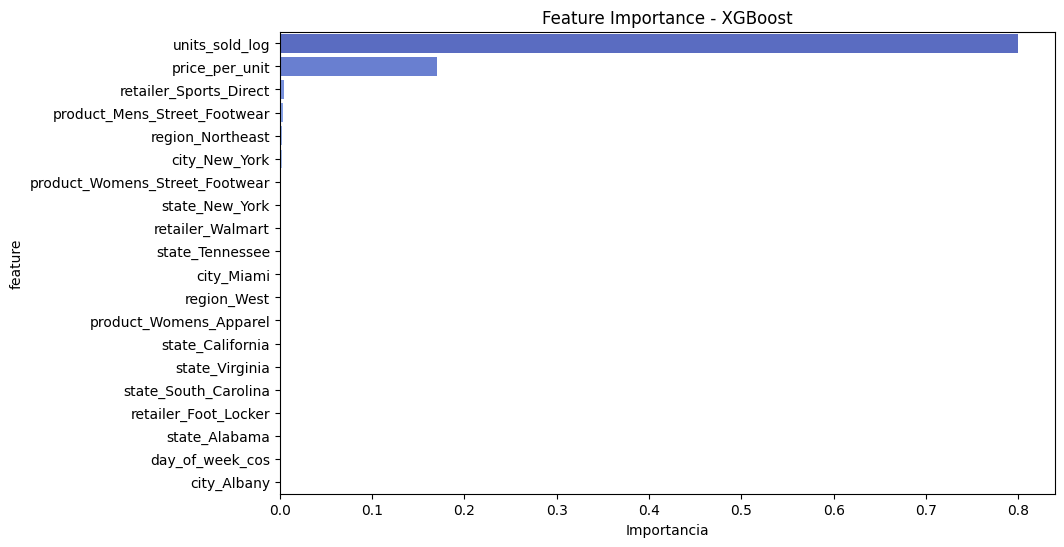

In [58]:
# Entrenar un modelo XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Importancia de features
feature_importances_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': xgb.feature_importances_})
feature_importances_xgb = feature_importances_xgb.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_xgb.importance[:20], y=feature_importances_xgb.feature[:20], palette="coolwarm")
plt.xlabel("Importancia")
plt.title("Feature Importance - XGBoost")
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18368\2813507265.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")


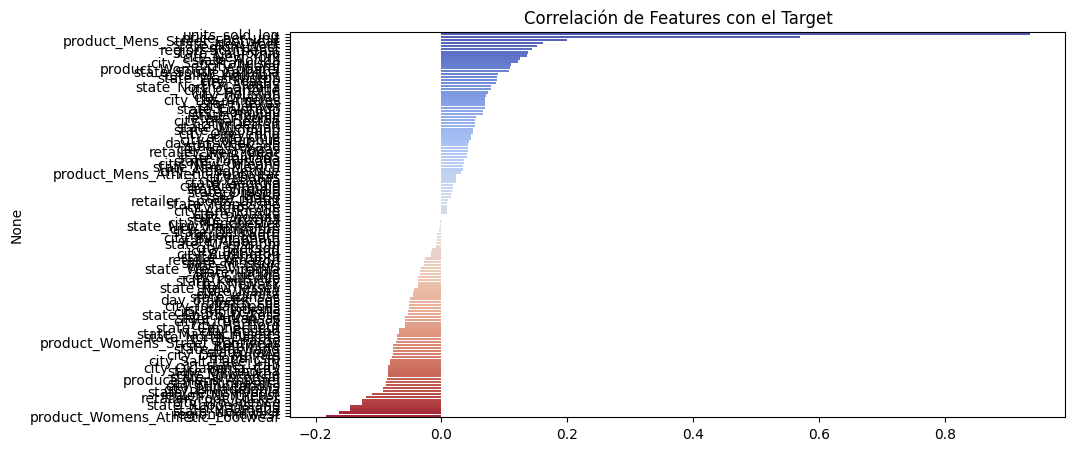

In [59]:
corr = X_train.corrwith(y_train_log).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Correlación de Features con el Target")
plt.show()

Entrenamos un modelo con todas las features:

In [60]:
# Modelo con todas las features
model_full = RandomForestRegressor(n_estimators=100, random_state=42)
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)
rmse_full = mean_squared_error(y_test, y_pred_full, squared=False)

TypeError: got an unexpected keyword argument 'squared'

Lo comparamos con el modelo y sus features seleccionadas:

In [ ]:
model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
model_reduced.fit(X_train_selected, y_train)
y_pred_reduced = model_reduced.predict(X_test_selected)
rmse_reduced = mean_squared_error(y_test, y_pred_reduced, squared=False)

print(f"RMSE con todas las features: {rmse_full:.2f}")
print(f"RMSE con features seleccionadas: {rmse_reduced:.2f}")

NameError: name 'X_train_selected' is not defined

# ✅ Step 6: Preparación del dataset de Train.


# ✅ Step 7: Selección e instanciación de modelos. Baseline.


# ✅ Step 8: Comparación de modelos.


# ✅ Step 9: Selección del modelo - Optimización de hiperparámetros.


# ✅ Step 10: Evaluación contra test.


# ✅ Step 11: Análisis de errores.


# ✅ Step 12: Persistencia del modelo en disco.